- play around with length of each data
- whete to slice

## Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os, math
import tensorflow as tf
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

dir = os.getcwd()
path = os.path.join(dir, 'zone_prod_70')
os.chdir(path)
print('Current working directory: {}'.format(os.getcwd()))


Current working directory: c:\Users\ryoii\OneDrive\Documents\work\zone_prod_70


## Read csv files

- _sequences: contains raw EEG data
- _labels: contains labels for the csv files
0 = base, 1 = target

In [2]:
def load_files(path):
    sequences = list()
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(path+'\\'+file, header=0)
            df = df.iloc[:, [2,3]]

            sequences.append(df.values)

    return sequences

train_base_sequences = load_files(os.path.join(os.getcwd(), 'train\\base'))
train_target_sequences = load_files(os.path.join(os.getcwd(), 'train\\target'))
test_base_sequences = load_files(os.path.join(os.getcwd(), 'test\\base'))
test_target_sequences = load_files(os.path.join(os.getcwd(), 'test\\target'))

print('Size of train combined: {}'.format(len(train_base_sequences) + len(train_target_sequences)))
print('Size of test combined: {}'.format(len(test_base_sequences) + len(test_target_sequences)))

Size of train combined: 567
Size of test combined: 119


In [3]:
# creating training, validation and test datasets
validation_len = math.ceil((len(test_base_sequences) + len(test_target_sequences))/2)

train_sequences = train_base_sequences[validation_len:] + train_target_sequences[validation_len:]
validation_sequences = train_base_sequences[:validation_len] + train_target_sequences[:validation_len]
test_sequences = test_base_sequences + test_target_sequences

print('Size of train_sequences: {}'.format(len(train_sequences)))
print('Size of validation_sequences: {}'.format(len(validation_sequences)))
print('Size of test_sequences: {}'.format(len(test_sequences)))


# creating labels for each datasets
train_labels = np.concatenate((np.zeros(len(train_base_sequences[validation_len:])), np.ones(len(train_target_sequences[validation_len:]))))
validation_labels = np.concatenate((np.zeros(len(train_base_sequences[:validation_len])), np.ones(len(train_target_sequences[:validation_len]))))
test_labels = np.concatenate((np.zeros(len(test_base_sequences)), np.ones(len(test_target_sequences))))

print('Shape of train_labels: {}'.format(train_labels.shape))
print('Shape of validation_labels: {}'.format(validation_labels.shape))
print('Shape of test_labels: {}'.format(test_labels.shape))


Size of train_sequences: 447
Size of validation_sequences: 120
Size of test_sequences: 119
Shape of train_labels: (447,)
Shape of validation_labels: (120,)
Shape of test_labels: (119,)


## Processing

#### 
- Identify minimum series and truncate all other series to that size
- Normalize

In [4]:
def truncate_seq(sequences):
    len_sequences = []

    for seq in (train_sequences + test_sequences):
        len_sequences.append(len(seq))

    min = pd.Series(len_sequences).describe()['min']

    return pad_sequences(sequences, maxlen=2000) #Remove values from the beginning of the sequence

truncated_train_sequences = truncate_seq(train_sequences)
truncated_validation_sequences = truncate_seq(validation_sequences)
truncated_test_sequences = truncate_seq(test_sequences)


print('Length of each data: {}'.format(len(truncated_train_sequences[0])))
print('Shape of truncated_train_sequences: {}'.format(truncated_train_sequences.shape))
print('Shape of truncated_validation_sequences: {}'.format(truncated_validation_sequences.shape))
print('Shape of truncated_test_sequences: {}'.format(truncated_test_sequences.shape))


Length of each data: 2000
Shape of truncated_train_sequences: (447, 2000, 2)
Shape of truncated_validation_sequences: (120, 2000, 2)
Shape of truncated_test_sequences: (119, 2000, 2)


## Building a Classification model

In [5]:
model = Sequential()
model.add(LSTM(256, input_shape=(truncated_train_sequences.shape[1], truncated_train_sequences.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               265216    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


In [6]:
adam = Adam(learning_rate=0.1)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(truncated_train_sequences, train_labels, epochs=10, batch_size=128, callbacks=[chk], shuffle=True, validation_data=(truncated_validation_sequences,validation_labels))

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5213 
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


4/4 [==============================] - 62s 16s/step - loss: 0.6969 - accuracy: 0.5213 - val_loss: 0.7215 - val_accuracy: 0.4917
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6376 
Epoch 2: val_accuracy improved from 0.49167 to 0.52500, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


4/4 [==============================] - 71s 19s/step - loss: 0.6156 - accuracy: 0.6376 - val_loss: 0.7262 - val_accuracy: 0.5250
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.6846 
Epoch 3: val_accuracy improved from 0.52500 to 0.56667, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl\assets


INFO:tensorflow:Assets written to: best_model.pkl\assets


4/4 [==============================] - 91s 24s/step - loss: 0.5735 - accuracy: 0.6846 - val_loss: 0.7199 - val_accuracy: 0.5667
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.7181 
Epoch 4: val_accuracy did not improve from 0.56667
4/4 [==============================] - 111s 28s/step - loss: 0.5449 - accuracy: 0.7181 - val_loss: 0.7345 - val_accuracy: 0.5250
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.7651 
Epoch 5: val_accuracy did not improve from 0.56667
4/4 [==============================] - 120s 31s/step - loss: 0.5191 - accuracy: 0.7651 - val_loss: 0.7400 - val_accuracy: 0.5167
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.7897 
Epoch 6: val_accuracy did not improve from 0.56667
4/4 [==============================] - 126s 32s/step - loss: 0.4925 - accuracy: 0.7897 - val_loss: 0.7474 - val_accuracy: 0.5500
Epoch 7/20
4/4 [==============================] - ETA

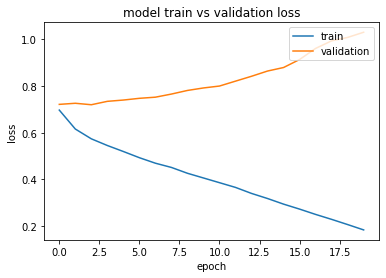

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing accuracy

In [8]:
model_path = os.path.join(os.getcwd(), 'best_model.pkl')
model = load_model(model_path)
test_preds = model.predict(truncated_test_sequences)
classes_pred=np.argmax(test_preds,axis=1)
accuracy_score(test_labels, classes_pred)

4/4 [==============================] - 8s 2s/step


0.4957983193277311